In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
pudl_engine  = pudl.db_connect_pudl()

### Pulling the required tables

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)

# In order to use the energy source associated with each generator
g8_es = g8[['plant_id','generator_id', 'energy_source_1']]
g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
g8_es.drop_duplicates(['plant_id','generator_id'], inplace=True)

# In order to use the capacity of each generator
g8 = g8[['plant_id','generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]
g8.rename(columns={'year': 'report_date'},inplace=True)

In [5]:
# # Cheating to duplicate 2015 EIA860 capacity factor data for 2016:
g8_2016 = g8.loc[g8['report_date'] == 2015]
g8_2016.report_date.replace([2015], [2016], inplace=True)
g8 = g8_2016.append(g8)

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
# Convert the fuel_receipts_costs_eia923 table into a dataframe
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])

In [7]:
# Get yearly fuel cost by plant_id, year and energy_source
frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id','report_date','energy_source'])
frc9_summed = frc9_summed.reset_index()

In [8]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

In [9]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [10]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

### Generating Capacity Factor

In [11]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] =\
            capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [12]:
# Remove unrealistic capacity factors: < 0 or > 1.5
capacity_factor = capacity_factor[capacity_factor.capacity_factor > 0]
capacity_factor = capacity_factor[capacity_factor.capacity_factor <= 1.5]

### Generating Fuel Cost

In [13]:
# Merge the generation table with the generator table to include energy_source
net_gen = g9_summed.merge(g8_es, how='left', on=['plant_id','generator_id'])
fuel_cost_per_mwh = net_gen.merge(frc9_summed,how='left',on=['plant_id','report_date','energy_source'])

In [14]:
# Sum the net generation by fuel type and year for each plant to calculation proportion of generation by each generator
net_gen_by_energy = fuel_cost_per_mwh.groupby(['plant_id', 'report_date', 'energy_source'])[["net_generation_mwh"]].sum()
net_gen_by_energy = net_gen_by_energy.reset_index()
fuel_cost_per_mwh = fuel_cost_per_mwh.merge(net_gen_by_energy, how='left', on=['plant_id', 'report_date', 'energy_source'])

In [15]:
# Calculate proportion of annual plant generation by each generator
fuel_cost_per_mwh['proportion_generation_by_gen'] = (fuel_cost_per_mwh.net_generation_mwh_x)/(fuel_cost_per_mwh.net_generation_mwh_y)
del fuel_cost_per_mwh['net_generation_mwh_y']
fuel_cost_per_mwh.rename(columns={'net_generation_mwh_x': 'net_generation_mwh'}, inplace=True)

In [16]:
# Calculate cost of fuel by generator
fuel_cost_per_mwh['fuel_cost_by_generator'] = fuel_cost_per_mwh['fuel_cost']*fuel_cost_per_mwh['proportion_generation_by_gen']

# Calculate fuel cost per mwh - will be the same for generators of same energy_source each year
fuel_cost_per_mwh['fuel_cost_per_mwh'] = fuel_cost_per_mwh['fuel_cost_by_generator'] / fuel_cost_per_mwh['net_generation_mwh']

In [17]:
fuel_cost_per_mwh.head()

,plant_id,report_date,generator_id,net_generation_mwh,energy_source,fuel_cost,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh
0,3,2009,1,221908.0,BIT,3.019373e+12,0.027594,8.331567e+10,375451.402359
1,3,2009,2,394031.0,BIT,3.019373e+12,0.048997,1.479395e+11,375451.402359
2,3,2009,3,1286393.0,BIT,3.019373e+12,0.159960,4.829781e+11,375451.402359
3,3,2009,4,1626547.0,BIT,3.019373e+12,0.202257,6.106894e+11,375451.402359
4,3,2009,5,4513101.0,BIT,3.019373e+12,0.561193,1.694450e+12,375451.402359


### Generating Heat Rate

##### Unassociated Generators

In [18]:
# This section generates heat rate from the generators
# of the plants that have any generators that are not
# included in the boiler generator association table (860)
# Because there are missing generators in the bga table,
# without lumping all of the heat input and generation
# from these plants together, the heat rates were off. 
# The vast majority of missing generators from the bga
# table seem to be the gas tubrine from combine cycle plants.
# This was generating heat rates for the steam generators
# alone, therefor much too low.

In [19]:
# All cenerators from the Boiler Generator Association table (860)
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
# All cenerators from the generation table (923)
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

# See which generators are missing from the bga table
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

# Create a list of plants that include any generators that are not in the bga table
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
unassociated_plants['plant_assn'] = False

# Using these unassociated_plants, lable all the generators that
# are a part of plants that have generators that are not included
# in the bga table
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

# Get a list of generators from plants with unassociated plants
gens_unassn_plants = gens[gens['plant_assn'] == False]

# Sum the yearly net generation for these plants
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

# Pull in mmbtu to calculate heat rate by plant
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

# Merge these plant level heat heat rates with the unassociated generators
# Assign heat rates to generators across the plants with unassociated generators
heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']],
                                            on=['plant_id','report_date'],how='left')
heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)

#### Associated Generators

In [20]:
# This section generates heat rate from the generators of
# the plants that have any generators that are included in
# the boiler generator association table (860)

In [21]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

# get net generation per boiler
gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

# get the generation per boiler/generator combo
gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

# squish them together
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                how='left', on=['plant_id','report_date','boiler_id'])

# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

# Use the proportion of the generation of each generator to allot mmBTU
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
bg_summed.reset_index(inplace=True)

# Calculate heat rate
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

# Importing the plant association tag to filter out the
# generators that are a part of plants that aren't in the bga table
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','plant_assn']], on=['plant_id','report_date','generator_id'])
heat_rate_assn = heat_rate[heat_rate['plant_assn'] == True]

#### Pull the Associated and Unassociated Generators

In [22]:
heat_rate_all = heat_rate_assn.append(heat_rate_unassn)

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


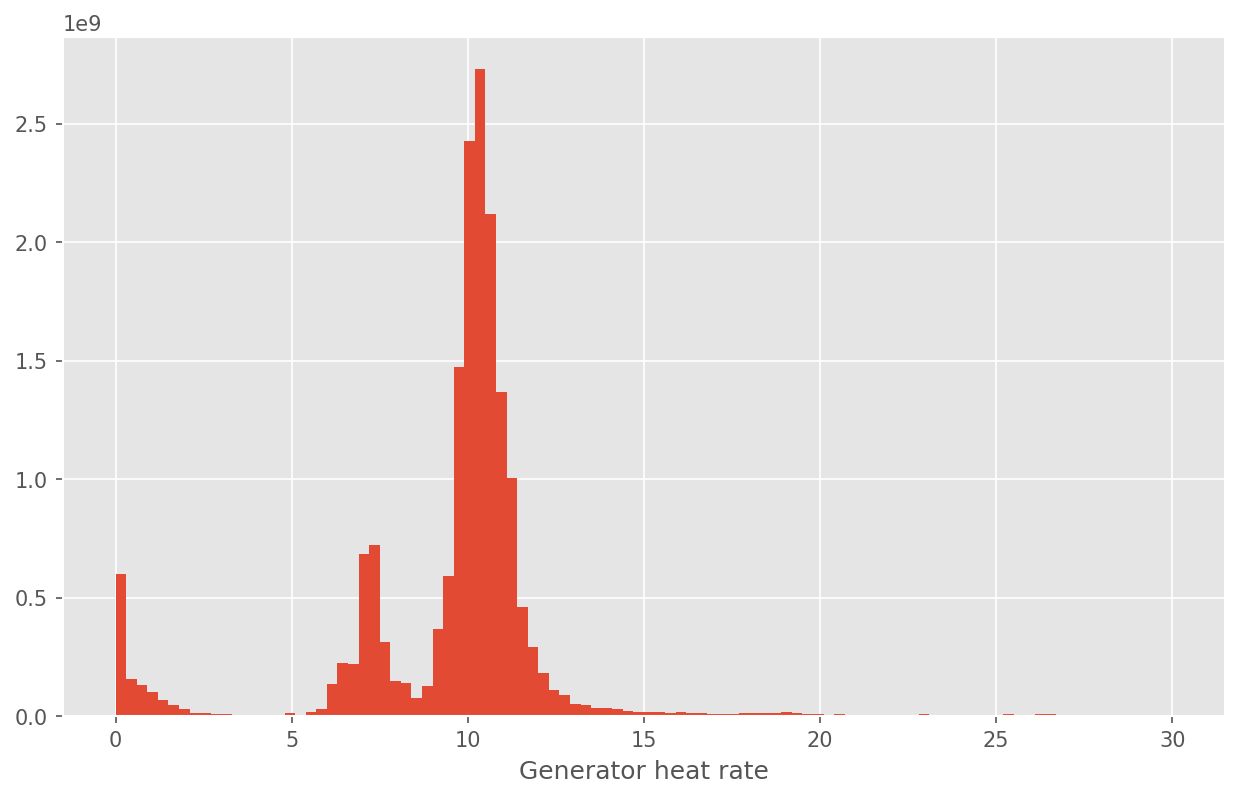

In [23]:
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,30],bins=100,weights=heat_rate_all.net_generation_mwh)
plt.xlabel('Generator heat rate')
plt.show()

### Merge fields together

In [24]:
mcoe_by_generator = fuel_cost_per_mwh.merge(heat_rate_all,on=['plant_id','report_date','generator_id'])

In [25]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor, on=['plant_id','report_date','generator_id'])

In [26]:
mcoe_by_generator.head()

,plant_id,report_date,generator_id,net_generation_mwh_x,energy_source,fuel_cost,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,net_generation_mwh_y,plant_assn,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,312130.0,BIT,2.025195e+12,0.067070,1.358305e+11,435172.890317,3.565315e+06,11.422532,312130.0,True,312130.0,153.1,138.0,138.0,0.232732
1,3,2011,2,191475.0,BIT,2.025195e+12,0.041144,8.332473e+10,435172.890317,2.286471e+06,11.941354,191475.0,True,191475.0,153.1,137.0,137.0,0.142769
2,3,2011,3,710069.0,BIT,2.025195e+12,0.152579,3.090028e+11,435172.890317,7.514980e+06,10.583450,710069.0,True,710069.0,272.0,249.0,249.0,0.298008
3,3,2011,4,1175685.0,BIT,2.025195e+12,0.252631,5.116262e+11,435172.890317,1.196932e+07,10.180722,1175685.0,True,1175685.0,403.7,362.0,362.0,0.332451
4,3,2011,5,2264413.0,BIT,2.025195e+12,0.486576,9.854112e+11,435172.890317,2.305600e+07,10.181889,2264413.0,True,2264413.0,788.8,726.5,726.5,0.327706


In [27]:
mcoe_by_generator.drop('net_generation_mwh_y', axis=1, inplace=True)
mcoe_by_generator.drop('net_generation_mwh_x', axis=1, inplace=True)
mcoe_by_generator.drop('fuel_cost', axis=1, inplace=True)

# Filter to include only plants >= 50 MW

In [28]:
# Now, let's grab only those plants larger than 50MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=50]

### Let's look at some data

In [29]:
mcoe_by_generator[mcoe_by_generator['plant_id'] == 3]

,plant_id,report_date,generator_id,energy_source,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,plant_assn,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,BIT,0.067070,1.358305e+11,435172.890317,3.565315e+06,11.422532,True,312130.0,153.1,138.0,138.0,0.232732
1,3,2011,2,BIT,0.041144,8.332473e+10,435172.890317,2.286471e+06,11.941354,True,191475.0,153.1,137.0,137.0,0.142769
2,3,2011,3,BIT,0.152579,3.090028e+11,435172.890317,7.514980e+06,10.583450,True,710069.0,272.0,249.0,249.0,0.298008
3,3,2011,4,BIT,0.252631,5.116262e+11,435172.890317,1.196932e+07,10.180722,True,1175685.0,403.7,362.0,362.0,0.332451
4,3,2011,5,BIT,0.486576,9.854112e+11,435172.890317,2.305600e+07,10.181889,True,2264413.0,788.8,726.5,726.5,0.327706
5,3,2011,A1ST,NG,0.502827,1.200333e+12,858917.671721,4.024245e+05,0.287961,True,1397495.0,195.2,173.0,192.0,0.817271
6,3,2011,A2ST,NG,0.497173,1.186836e+12,858917.671721,3.467116e+05,0.250916,True,1381781.0,195.2,173.0,192.0,0.808082
7,3,2012,1,BIT,0.028595,8.069661e+10,530542.750435,1.743140e+06,11.460336,True,152102.0,153.1,138.0,138.0,0.113411
8,3,2012,2,BIT,0.023201,6.547428e+10,530542.750435,1.493954e+06,12.105616,True,123410.0,153.1,137.0,137.0,0.092018
9,3,2012,3,BIT,0.093353,2.634447e+11,530542.750435,5.284706e+06,10.642697,True,496557.0,272.0,249.0,249.0,0.208399


In [30]:
mcoe_by_generator.sample(10)

,plant_id,report_date,generator_id,energy_source,proportion_generation_by_gen,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,plant_assn,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
4177,2240,2012,8,SUB,0.781913,6.810655e+10,1.924806e+05,4.175541e+06,11.800781,True,353836.0,91.5,85.0,85.0,0.441445
15486,55197,2015,CTG2,NG,0.187406,1.284699e+11,2.008250e+05,NaN,7.242606,False,639711.0,161.0,157.0,187.0,0.453580
2307,1043,2013,1,BIT,0.517310,4.042127e+10,1.235633e+05,3.586300e+06,10.962920,True,327130.0,116.6,112.0,117.0,0.320271
7399,6061,2013,1,BIT,0.252827,1.013868e+11,4.046070e+05,2.899826e+06,11.572408,True,250581.0,200.0,180.0,200.0,0.143026
7891,6181,2011,2,SUB,0.478948,1.273825e+12,4.209457e+05,3.032703e+07,10.021811,True,3026103.0,446.0,436.0,436.0,0.774542
4284,2330,2015,1,NG,0.558015,7.010766e+10,4.077544e+05,2.003168e+06,11.650663,True,171936.0,115.0,113.0,113.0,0.170673
5651,3181,2011,3,BIT,1.000000,NaN,NaN,8.265395e+06,10.801755,True,765190.0,299.2,278.0,288.0,0.291947
8431,7302,2013,4ST,NG,0.270434,1.386043e+12,1.254685e+06,0.000000e+00,0.000000,True,1104694.0,212.0,170.0,180.0,0.594843
6585,3797,2015,6,BIT,0.622393,1.115552e+12,2.723134e+05,NaN,9.195616,False,4096576.0,693.9,670.0,690.0,0.673938
14923,55065,2015,GEN1,NG,0.660569,8.422280e+10,3.026886e+05,NaN,11.522788,False,278249.0,174.2,159.0,162.0,0.182340


/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


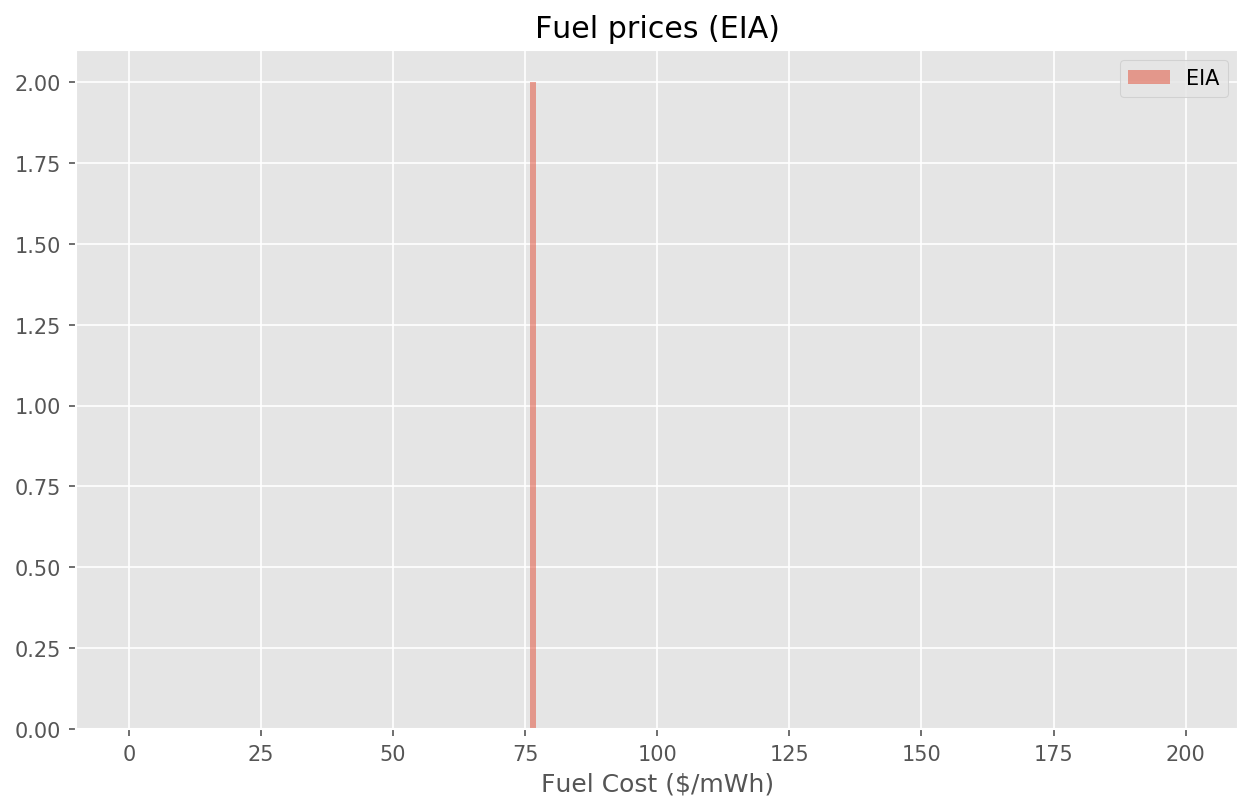

In [35]:
#quick look at spread in fuel_cost_per_mwh - how do we tell what's realistic?
plt.hist(mcoe_by_generator.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, label="EIA");
plt.xlabel("Fuel Cost ($/mWh)");
plt.title("Fuel prices (EIA)")
plt.legend();

In [32]:
mcoe_by_generator.fuel_cost_per_mwh.describe()

count    6.534000e+03
mean     5.687380e+05
std      7.325432e+06
min     -1.316773e+07
25%      2.083935e+05
50%      2.812428e+05
75%      4.520163e+05
max      5.079073e+08
Name: fuel_cost_per_mwh, dtype: float64

In [33]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations.csv')

In [34]:
xlsx_writer = pd.ExcelWriter('EIA_mcoe_2011-2015.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False)
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
xlsx_writer.save()